In [0]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3, preprocess_input


from google.colab import drive
drive.mount("/content/gdrive")

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
drive_base_path = "/content/gdrive/My Drive/Minor Project/"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_image_aug = drive_base_path + "dataset/ISIC2018_VGG16_Training_AUG/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [0]:
directory_images = os.listdir(path_to_images)
image_file = directory_images[100]
image_file[:-4]

'ISIC_0033427'

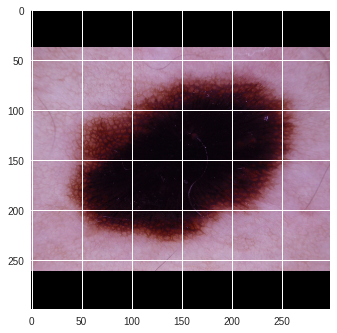

In [0]:
# all image sizes are 600x450
INPUT_SIZE = 299

img = cv2.imread(path_to_images + image_file)
# parse BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
old_size = img.shape[:2] # height, width

# rescale
ratio = float(INPUT_SIZE)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# resize with new size
img = cv2.resize(img, (new_size[1], new_size[0])) # width, height
# plt.imshow(img)

# padding the image to make it a square
delta_w = INPUT_SIZE - new_size[1]
delta_h = INPUT_SIZE - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                            value=color)

plt.imshow(new_img)

In [0]:
def create_train_test(path_to_images, path_to_description, test_split=0.0):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    input_size = 299
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)
        
        X_train.append(new_img)
    
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_train.append([int(float(x)) for x in row[1:]])
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_split, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [0]:
X_train, X_test, y_train, y_test = create_train_test(path_to_images, path_to_description)

In [0]:
with open(drive_base_path + "dataset/pickled-data/InceptionV3_ISIC_2018_data.pkl", "wb") as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)

In [0]:
with open(drive_base_path + "dataset/pickled-data/InceptionV3_ISIC_2018_data.pkl", "rb") as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [0]:
print("Training X Size", X_train.shape)
print("Training Y Size \(Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofibroma, Vascular Lesion\)", y_train.shape)
for i in range(5):
    print(X_train[i].shape, y_train[i])

Training X Size (10015, 299, 299, 3)
Training Y Size \(Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofibroma, Vascular Lesion\) (10015, 7)
(299, 299, 3) [0 1 0 0 0 0 0]
(299, 299, 3) [0 1 0 0 0 0 0]
(299, 299, 3) [0 1 0 0 0 0 0]
(299, 299, 3) [0 1 0 0 0 0 0]
(299, 299, 3) [1 0 0 0 0 0 0]


In [0]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2)

datagen.fit(X_train[:500])

In [0]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_

In [0]:
batch_size = 1
epochs = 2
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(X_train) / batch_size, 
                              epochs=epochs, 
                              verbose=1, 
                              validation_split=0.1)

In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])
epochs = 10
batch_size = 32
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=len(X_train) / batch_size, 
                              epochs=epochs, verbose=1, 
                              shuffle=True)
model.save_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

Train on 4000 samples, validate on 1001 samples
Epoch 1/10
4000/4000 [==============================] - 89s 22ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 2/10
4000/4000 [==============================] - 83s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 3/10
4000/4000 [==============================] - 84s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 4/10
4000/4000 [==============================] - 84s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 5/10
4000/4000 [==============================] - 83s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 6/10
4000/4000 [==============================] - 84s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503
Epoch 7/10
4000/4000 [==============================] - 84s 21ms/step - loss: 5.5728 - acc: 0.6543 - val_loss: 5.6357 - val_acc: 0.6503


KeyboardInterrupt: ignored

In [0]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Validation_Input/"

In [0]:
list_of_images = os.listdir(path_to_images)
filename = list_of_images[0]
print(filename[:-4])
input_size = 224

image = cv2.imread(path_to_images + filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
old_size = image.shape[:2]

ratio = float(input_size)/max(old_size)
new_size = tuple([int(x * ratio) for x in old_size])

image = cv2.resize(image, (new_size[1], new_size[0]))

delta_w = input_size - new_size[1]
delta_h = input_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                             cv2.BORDER_CONSTANT, value=color)

plt.imshow(new_img)


In [0]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)

#         arr = np.array(image)
        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [0]:
x, names = preprocess_images(path_to_images)

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False,
    rescale=1. /255.,
    fill_mode='nearest',
    data_format="channels_last",
    shuffle=False)

datagen.fit(x)

In [0]:
print("X Shape", x.shape)
plt.imshow(x[60])
print("Name Shape", names.shape)

In [0]:
model.load_weights(drive_base_path + 'models/InceptionV3Net_ISIC_cnn.h5')

In [0]:
predictions = model.predict_generator(datagen.flow(x, batch_size=1))
classes = (predictions > 0.5).astype(np.float)
print(classes.shape)

In [0]:
final_output = np.concatenate((names, classes), axis=1)
final_output.shape

In [0]:
import csv

with open("output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)